# 8. Dimensionality Reduction

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/0xInode/AI-study-notes/blob/main/ml/hands-on-ml/chapter08/chapter08.ipynb)


머신러닝 문제는 각 훈련 샘플마다 수천 - 수백만 개의 특성 포함  
이러한 모든 특성은 훈련을 매우 느리게 만들 뿐만 아니라 좋은 해법을 찾기 어렵게 만듦  
-> 차원의 저주(curse of dimensionality)

특성 수를 상당히 줄여 불가능한 문제를 해결 가능한 문제로 바꾸는 것이 종종 가능

3장에서 소개된 MNIST 이미지의 경우
- 이미지 테두리의 픽셀은 거의 항상 흰색이므로 이 픽셀을 훈련 세트에서 완전히 제거해도 정보 손실이 거의 없음
- 또한 인접한 두 픽셀은 종종 높은 상관관계를 가지므로
이 둘을 하나의 픽셀로 병합(예: 두 픽셀 강도의 평균 사용)하면 정보 손실이 거의 없음

차원 축소는 일부 정보 손실을 수반  
(이미지를 JPEG로 압축하면 품질이 저하되는 것과 같음)  
-> 훈련 속도는 빨라지지만 시스템의 성능이 약간 떨어질 수 있음

파이프라인을 더 복잡하게 만들어 유지 관리가 어려워짐  
그러므로 훈련 속도가 너무 느릴 경우 차원 축소를 사용하기 전에 먼저 원본  데이터를 그대로 사용해 시스템을 훈련해 보는 것이 좋음  

어떤 경우에는 차원 축소가 훈련 데이터의 노이즈나 불필요한 세부 정보를 걸러내어 성능을 높일 수도 있지만, 일반적으로는 성능 향상이 아닌 **훈련 속도 향상이 목적**

훈련 속도를 높이는 것 외에도 데이터 시각화(DataViz)에 매우 유용  
차원을 2개(또는 3개)로 줄이면 고차원 훈련 세트를 그래프 상에서 축약된 형태로 시각화할 수 있음  
이를 통해 클러스터와 같은 패턴을 시각적으로 탐지하여 중요한 통찰을 얻을 수 있음  
또한 DataViz는 데이터 과학자가 아닌 사람, 특히 결과를 활용할 의사결정권자에게 결론을 전달하는 데 필수적

## Setup

In [2]:
import sys

assert sys.version_info >= (3, 7)

In [3]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [4]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [5]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "dim_reduction"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## The Curse of Dimensionality

우리는 3차원 공간에 익숙하기 때문에 고차원 공간을 상상하려 하면 직관이 무너짐  
기본적인 4차원 초입방체조차 머릿속에서 그리기 매우 어려움  
하물며 1,000차원 공간 속에 구부러진 200차원 타원체는 더더욱 상상하기 어려움

고차원 공간에서는 많은 것이 매우 다르게 작동함  
예를 들어 단위 정사각형(1 × 1)에서 임의의 점을 선택할 경우  
그 점이 경계로부터 0.001보다 가까이 있을 확률은 약 0.4%에 불과함  
즉, 임의의 점이 어떤 차원에서 극단적일 가능성은 매우 낮음  
하지만 10,000차원 단위 초입방체에서는 이 확률이 99.999999%를 넘음  
대부분의 점이 경계에 매우 가까움

단위 정사각형에서 임의로 두 점을 고르면 두 점 사이의 평균 거리는 약 0.52  
단위 3차원 정육면체에서는 평균 거리가 약 0.66  

1,000,000차원 초입방체에서 두 점을 임의로 고르면?  
평균 거리는 약 408.25(대략 1,000,000 ÷ 6)  
→ **직관에 어긋남**

어떻게 두 점이 같은 단위 초입방체 안에 있으면서도 이렇게 멀 수 있을까  
그 이유는 고차원 공간에는 그만큼 엄청난 여유 공간이 있기 때문

이로 인해 고차원 데이터셋은 매우 **희소(sparse)**해질 위험  
→ 대부분의 훈련 샘플들이 서로 멀리 떨어져 있게 됨  
→ 따라서 새로운 샘플도 기존 훈련 샘플과 멀리 떨어져 있을 가능성이 높음  
→ 예측이 저차원보다 **훨씬 큰 외삽(extrapolation)**에 의존하게 되어 신뢰도가 떨어짐

> 훈련 세트의 차원이 많아질수록 **과적합(overfitting)**의 위험이 커짐

이론적으로 차원의 저주를 해결하려면 훈련 샘플 수를 증가시키는 방안이 있음  
(훈련 샘플 간 밀도를 높이면 희소성을 줄일 수 있으므로)

하지만 실제로는  
차원이 늘어날수록 필요한 훈련 샘플 수는 지수적으로 증가  
특성이 100개뿐이라도  
모든 차원에 걸쳐 고르게 퍼졌다고 가정,  
각 샘플이 평균적으로 서로 0.1 이내에 있도록 하려면  
관측 가능한 우주의 원자 수보다 많은 훈련 샘플이 필요  

## Main Approaches for Dimensionality Reduction

차원 축소의 두 가지 주요 접근 방식
- 투영(projection)
- 매니폴드 학습(Manifold Learning)

### Projection

현실 세계의 대부분 문제에서 훈련 샘플은 모든 차원에 걸쳐 균일하게 퍼져 있지 않음
- 많은 특성은 거의 값이 일정
- 일부 특성은 서로 강한 상관관계
- 그 결과 모든 훈련 샘플은 고차원 공간의 훨씬 낮은 차원의 부분공간(subspace) 안에(또는 그 근처에) 존재

모든 훈련 샘플이 한 평면에 가까이 몰려 있음  
→ 이는 고차원(3D) 공간의 더 낮은 차원(2D) 부분공간

모든 훈련 샘플을 이 부분공간에 수직으로 투영하면    
(각 샘플에서 평면까지 이어지는 짧은 선으로 표시됨)  
새로운 2차원 데이터셋이 만들어짐

이렇게 해서 데이터의 차원을 3D에서 2D로 줄인 것임    
이때 축은 새로운 특성 $𝑧_1$, $𝑧_2$에 해당(평면 위 투영점의 좌표)

하지만 투영이 항상 차원 축소에 최적의 방법은 아님  
많은 경우, 부분공간이 구부러지고 뒤틀려 있음  
→ Swiss roll(스위스 롤) 장난감 데이터셋이 대표적 예시

단순히 한 평면에 투영하는 방식(예: 𝑥3을 버리는 방식)은  
Swiss roll의 서로 다른 층들이 짓눌려 겹쳐지게 됨

실제로 원하는 것은 Swiss roll을 펴서 펼친 뒤  
진짜 2차원 구조를 얻는 것

### Manifold Learning

Swiss roll은 **2차원 매니폴드(2D manifold)**의 예시  
2차원 매니폴드는 고차원 공간 안에서 구부러지거나 휘어질 수 있는 2차원 형태

d차원 매니폴드:
d < n인 경우, n차원 공간의 일부로서 국소적으로는 d차원 초평면처럼 보이는 구조

Swiss roll의 경우 d = 2, n = 3  
→ 지역적으로는 2D 평면처럼 보이지만, 실제로는 3차원 공간 안에서 말려 있음

많은 차원 축소 알고리즘은 훈련 샘플들이 놓여 있는 이 매니폴드를 모델링함
→ **매니폴드 학습(Manifold Learning)**

이는 **매니폴드 가정(manifold assumption 또는 manifold hypothesis)**에 기반
→ 대부분의 현실 고차원 데이터셋은 훨씬 낮은 차원의 매니폴드 근처에 존재한다는 가정(실제로 자주 관찰됨)

MNIST 데이터셋의 경우  
모든 손글씨 숫자 이미지는 몇 가지 공통된 특징 가짐
- 선들이 연결되어 있음
- 배경은 하얗고
- 대체로 가운데에 위치

이미지를 무작위로 생성하면 그중 극소수만이 실제 손글씨 숫자처럼 보일 것  
→ 손글씨 숫자를 생성할 때의 **자유도(degree of freedom)**는 임의의 이미지를 생성할 때보다 훨씬 낮음

이러한 제약들이 데이터셋을 더 낮은 차원의 매니폴드로 압축시키는 결과를 낳음

매니폴드 가정에 또 하나의 암묵적 가정  
→ 문제(예: 분류, 회귀)가 매니폴드 상의 저차원 공간에서 더 단순해진다는 가정

Swiss roll이 두 클래스로 나뉘어 있음  
3D 공간(왼쪽)에서는 복잡한 결정 경계가 필요  
2D로 펼친 매니폴드 공간(오른쪽)에서는 직선 경계로 충분  
(하지만 이 가정이 항상 맞는 것은 아님)

결정 경계 𝑥1=5  
원래 3D 공간에서는 단순한 수직 평면
하지만 매니폴드를 펼치면 복잡한 네 개의 선분 조각


>훈련 세트를 차원 축소하면 훈련 속도는 일반적으로 빨라지지만
해법이 더 단순하거나 더 나은 것이 될지는 데이터셋에 따라 다름

## PCA

**주성분 분석(PCA, Principal Component Analysis)**  
- 가장 널리 사용되는 차원 축소 알고리즘
- 우선 데이터에 **가장 가까운 초평면(hyperplane)**을 찾고
- 그 다음 데이터를 그 초평면에 투영


In [6]:
import numpy as np
from scipy.spatial.transform import Rotation
m = 60
X = np.zeros((m, 3))  # 3차원 데이터셋 초기화
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # 각도를 비균등하게 생성
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # 타원 형태로 배치
X += 0.28 * np.random.randn(m, 3)  # 잡음 추가하여 데이터 퍼뜨림
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)  # 회전을 적용해 방향 왜곡
X += [0.2, 0, 0.2]  # 데이터셋을 약간 이동시켜 중심 조정


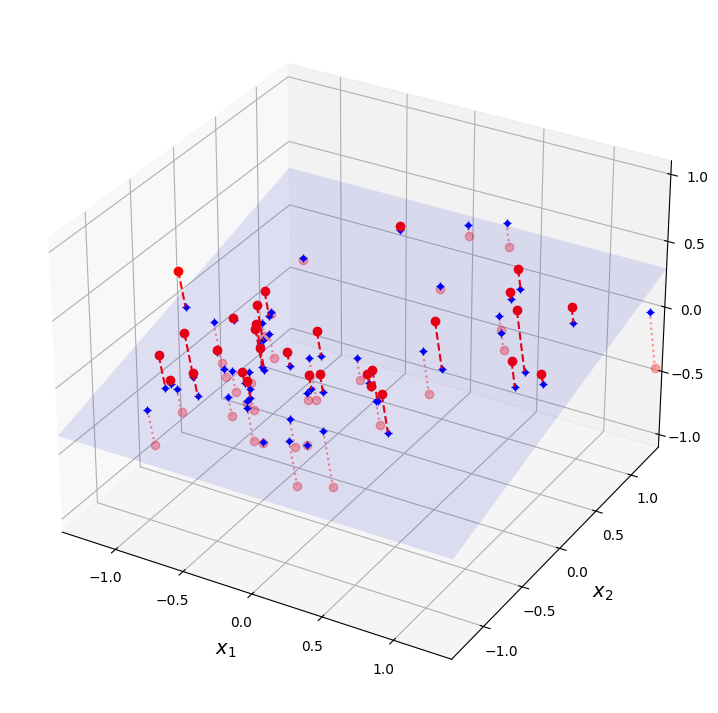

In [7]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)  # PCA로 2차원으로 차원 축소
X3D_inv = pca.inverse_transform(X2D)  # 2D 투영 결과를 3D 공간으로 다시 복원
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)

axes = [-1.4, 1.4, -1.4, 1.4, -1.1, 1.1]
x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 10),
                     np.linspace(axes[2], axes[3], 10))
w1, w2 = np.linalg.solve(Vt[:2, :2], Vt[:2, 2])  # 투영 평면의 계수 계산
z = w1 * (x1 - pca.mean_[0]) + w2 * (x2 - pca.mean_[1]) - pca.mean_[2]  # 투영 평면 정의
X3D_above = X[X[:, 2] >= X3D_inv[:, 2]]  # 평면 위에 있는 샘플
X3D_below = X[X[:, 2] < X3D_inv[:, 2]]  # 평면 아래에 있는 샘플

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection="3d")

# 평면 아래의 샘플과 투영선 먼저 그림
ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "ro", alpha=0.3)
for i in range(m):
    if X[i, 2] < X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], ":", color="#F88")

ax.plot_surface(x1, x2, z, alpha=0.1, color="b")  # PCA 투영 평면
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b+")  # 투영된 샘플
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b.")

# 평면 위의 샘플과 투영선 그리기
for i in range(m):
    if X[i, 2] >= X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], "r--")

ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "ro")

def set_xyz_axes(ax, axes):
    ax.xaxis.set_rotate_label(False)
    ax.yaxis.set_rotate_label(False)
    ax.zaxis.set_rotate_label(False)
    ax.set_xlabel("$x_1$", labelpad=8, rotation=0)
    ax.set_ylabel("$x_2$", labelpad=8, rotation=0)
    ax.set_zlabel("$x_3$", labelpad=8, rotation=0)
    ax.set_xlim(axes[0:2])
    ax.set_ylim(axes[2:4])
    ax.set_zlim(axes[4:6])

set_xyz_axes(ax, axes)
ax.set_zticks([-1, -0.5, 0, 0.5, 1])

save_fig("dataset_3d_plot", tight_layout=False)  # 3D 투영 결과를 파일로 저장
plt.show()


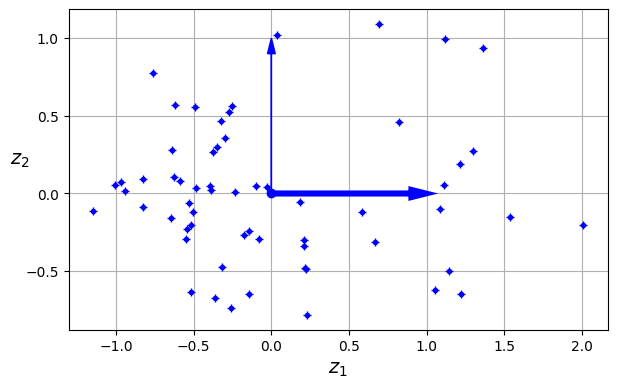

In [8]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.plot(X2D[:, 0], X2D[:, 1], "b+")  # 투영된 2D 샘플 점 찍기
ax.plot(X2D[:, 0], X2D[:, 1], "b.")
ax.plot([0], [0], "bo")  # 원점을 표시

# 첫 번째 주성분 방향 화살표
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True,
         head_length=0.1, fc='b', ec='b', linewidth=4)

# 두 번째 주성분 방향 화살표
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True,
         head_length=0.1, fc='b', ec='b', linewidth=1)

ax.set_xlabel("$z_1$")
ax.set_yticks([-0.5, 0, 0.5, 1])
ax.set_ylabel("$z_2$", rotation=0)
ax.set_axisbelow(True)
ax.grid(True)

save_fig("dataset_2d_plot")  # 2D 투영 결과를 파일로 저장


### Preserving the Variance

훈련 세트를 더 낮은 차원의 초평면에 투영하기 전에
먼저 적절한 초평면을 선택

다음 그림 왼쪽에는 세 개의 서로 다른 축(1차원 초평면)이 표시  
오른쪽에는 각 축에 대해 데이터셋을 투영한 결과
- 실선(solid line)에 투영한 경우: 분산이 최대로 보존됨
- 점선(dotted line)에 투영한 경우: 분산이 거의 없음
- 파선(dashed line)에 투영한 경우: 중간 정도 분산이 보존됨

→ 가장 많은 **분산(variance)**을 보존하는 축을 선택하는 것이 합리적으로 보임  
→ 이는 다른 축에 비해 정보 손실이 가장 적을 가능성이 높음

또 다른 관점에서 보면  
이 축은 **원본 데이터와 투영된 데이터 간 평균 제곱 거리(mean squared distance)**를 최소화하는 축  
=> PCA의 핵심 아이디어

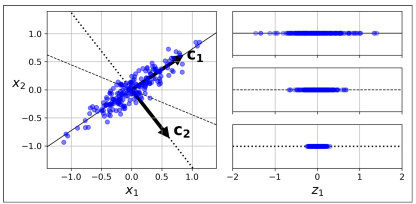

### Principal Components

1. PCA는 훈련 세트에서 분산이 가장 큰 방향의 축을 찾음(위 그림의 실선)
2. 그 다음에는 첫 번째 축과 직교하는 두 번째 축을 찾아
3. 남은 분산 중 가장 많은 양을 설명하는 방향을 찾음
(2차원 예시에서는 선택의 여지가 없으며, 점선이 두 번째 축)
4. 데이터가 더 높은 차원일 경우
PCA는 세 번째 축, 네 번째 축 등 **모든 차원 수만큼의 직교 축(principal components, PCs)**을 찾아냄

$i^{th}$ 축은 $i^{th}$ 번 **주성분(PC, Principal Component)**  
- 첫 번째 주성분은 벡터 $𝑐_1$이 놓인 축  
- 두 번째 주성분은 벡터 $𝑐_2$이 놓인 축



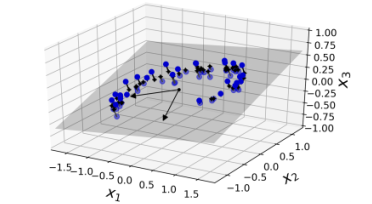

위 그림에서는  
첫 두 개의 주성분: 평면 위의 두 개의 직교 화살표   
세 번째 주성분: 그 평면에 수직인 축  
PCA는 각 주성분마다 방향을 나타내는 **단위 벡터(길이 1이고 중심이 원점인 벡터)**를 구함

- 이 벡터는 방향만 정의하므로
벡터가 반대 방향을 가리키더라도 동일한 축
- 훈련 세트에 조금이라도 변동이 생기면
벡터 방향이 바뀔 수 있지만 여전히 같은 축
- 경우에 따라 벡터 쌍이 서로 바뀔 수도 있으나
(해당 축들의 분산이 비슷할 경우)
 이들이 정의하는 평면 자체는 유지

주성분 찾는 방법: **특이값 분해(SVD, Singular Value Decomposition)**라는
표준 행렬 분해 기법 사용

→ 훈련 세트 행렬 𝑋를 다음 세 행렬 곱으로 분해함  
$X = U \Sigma V^\top$


여기서 **$𝑉$**는 우리가 원하는
주성분 방향 벡터들을 담고 있음  
$\mathbf{V} = \begin{pmatrix} \vert & \vert & & \vert \\ \mathbf{c}_1 & \mathbf{c}_2 & \cdots & \mathbf{c}_n \\ \vert & \vert & & \vert \end{pmatrix}$


In [9]:
import numpy as np
from scipy.spatial.transform import Rotation
m=60
X = np.zeros((m, 3))  # 3차원 데이터셋 초기화
X_centered = X - X.mean(axis=0)  # 원점을 기준으로 데이터 중심 정렬
U, s, Vt = np.linalg.svd(X_centered)  # 특이값 분해(SVD) 수행: 훈련 세트의 모든 주성분 구함
c1 = Vt[0]  # 첫 번째 주성분 방향 벡터
c2 = Vt[1]  # 두 번째 주성분 방향 벡터


PCA는 데이터셋이 원점을 중심으로 정렬되어 있다고 가정  
Scikit-Learn의 PCA 클래스는 이 중심 정렬을 자동으로 처리

직접 PCA를 구현하거나 다른 라이브러리를 사용할 경우  
먼저 데이터를 중심으로 정렬하는 것을 잊지 말아야 함!

### Projecting Down to d Dimensions

식별한 모든 주성분을 바탕으로 d차원으로 데이터셋의 차원을 축소하려면
처음 d개의 주성분으로 정의된 초평면에 데이터를 투영하면 됨
이 초평면을 선택하면 투영 시 가능한 많은 분산을 보존할 수 있음

예를 들어 이전 그림에서는 3차원 데이터셋을 처음 두 개의 주성분이 정의한 2차원 평면에 투영
그 결과 2차원 투영 결과가 원래의 3차원 데이터셋과 매우 유사하게 보임

학습 세트를 초평면에 투영하고 차원이 축소된 데이터셋
$𝑋_{𝑑−𝑝𝑟𝑜𝑗}$를 얻으려면   
학습 세트 행렬 $𝑋$에 행렬 $𝑊_𝑑$를 곱하면 됨  
여기서 $𝑊_𝑑$는 행렬 $𝑉$의 처음 d개의 열로 구성

$X_{d\text{-proj}} = XW_d$

In [10]:
W2 = Vt[:2].T  # 처음 두 개의 주성분 벡터를 열벡터로 변환하여 투영 행렬 생성
X2D = X_centered @ W2  # 데이터를 주성분 평면에 투영하여 2차원으로 차원 축소


### Using Scikit-Learn

Scikit-Learn의 PCA 클래스는 SVD 분해를 사용해 PCA 구현

다음 코드는 데이터셋의 차원을 자동으로 중심화한 뒤 2차원으로 축소

In [11]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)  # 주성분 2개를 사용하여 차원 축소를 수행하는 PCA 객체 생성
X2D = pca.fit_transform(X)  # 데이터에 PCA를 적용하고 2차원으로 변환된 결과 반환


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


In [12]:
pca.components_

array([[0., 0., 1.],
       [0., 1., 0.]])

PCA 변환기를 데이터셋에 적합시키면
`pca.components_` 속성은 $𝑊_𝑑$의 전치행렬을 담게 됨  
-> scikit-learn은 데이터를 행 기준으로 다루므로 행벡터에 오른쪽에서 곱할 행렬을 만들어야 하니까?!
- $W_d \in \mathbb{R}^{d \times k}$
- `pca.components_` = $W_d^\top \in \mathbb{R}^{k \times d}$

예를 들어 첫 번째 주성분을 정의하는 단위벡터는 pca.components_.T[:, 0]과 같음

### Explained Variance Ratio

각 주성분의 설명 분산 비율: `explained_variance_ratio_` 변수로 확인  
-> 각 주성분 방향에 데이터셋의 분산이 얼마나 놓여 있는지를 나타냄

In [13]:
pca.explained_variance_ratio_

array([nan, nan])

In [14]:
1 - pca.explained_variance_ratio_.sum()  # 제거된 주성분들이 담고 있던 분산의 비율 계산


np.float64(nan)

전체 분산 중
- 첫 번째 주성분 방향에 약 75.5%
- 두 번째 주성분 방향에 약 16.4%가 위치
- 세 번째 주성분에 남는 분산은 8.1% 미만

### Choosing the Right Number of Dimensions

- 임의로 차원 수를 정하는 대신 전체 분산에서 충분히 큰 비율(예: 95%)을 차지하는 차원 수를 선택하는 것이 더 간단함
- 시각화를 목적으로 하는 경우라면 2차원이나 3차원으로 줄이는 것이 더 나음

차원을 줄이지 않고 PCA를 수행한 뒤 훈련 세트의 분산을 95% 이상 보존하는 데 필요한 최소 차원 수 계산해 보기

In [15]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False, parser="auto")
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)  # 누적 설명 분산 비율 계산
d = np.argmax(cumsum >= 0.95) + 1  # 전체 분산의 95%를 보존하는 데 필요한 최소 차원 수(+1은 파이썬 인덱스 보정)


In [16]:
d

np.int64(154)

이후 `n_components=d` 로 설정하여 PCA를 다시 수행할 수 있음

하지만 보존하려는 분산 비율을 0.0~1.0 사이의 실수로 직접 지정하는 것이 더 나음!

In [17]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [18]:
d

np.int64(154)

In [19]:
pca.n_components_

np.int64(154)

In [20]:
pca.explained_variance_ratio_.sum()

np.float64(0.9501960192613031)

또 다른 방법은 설명 분산을 차원의 수에 따라 플로팅(cumsum을 단순히 플로팅)

일반적으로 곡선에서 설명 분산이 급격히 증가하지 않게 되는 지점에 엘보가 나타남  
이 경우 약 100차원으로 차원 축소해도 설명 분산 손실이 크지 않음

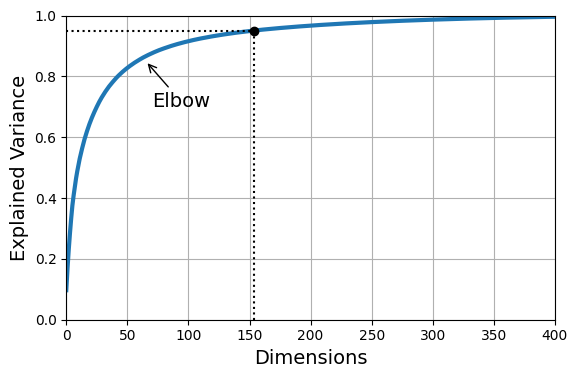

In [21]:
plt.figure(figsize=(6, 4))
plt.plot(cumsum, linewidth=3)  # 누적 설명 분산 시각화
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")  # 임계 차원 d에서 수직선 표시
plt.plot([0, d], [0.95, 0.95], "k:")  # 설명 분산 95%에서 수평선 표시
plt.plot(d, 0.95, "ko")  # 임계점 강조
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),  # 엘보 지점 주석 및 화살표 표시
             arrowprops=dict(arrowstyle="->"))
plt.grid(True)
save_fig("explained_variance_plot")  # 그래프 이미지 저장
plt.show()


In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV  # 무작위 탐색 기반 하이퍼파라미터 튜닝 도구 임포트
from sklearn.pipeline import make_pipeline

clf = make_pipeline(PCA(random_state=42),
                    RandomForestClassifier(random_state=42))  # PCA와 랜덤포레스트를 연결한 파이프라인 생성
param_distrib = {
    "pca__n_components": np.arange(10, 80),  # PCA 차원 수 탐색 범위
    "randomforestclassifier__n_estimators": np.arange(50, 500)  # 트리 개수 탐색 범위
}
rnd_search = RandomizedSearchCV(clf, param_distrib, n_iter=10, cv=3,
                                random_state=42)  # 무작위 탐색 기반의 하이퍼파라미터 튜닝 설정
rnd_search.fit(X_train[:1000], y_train[:1000])  # 훈련 데이터 일부에 대해 탐색 수행


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       6...
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       492, 493, 494, 495, 496, 497, 498, 499])},
                   random_state=42)

In [23]:
print(rnd_search.best_params_)  # 최적의 하이퍼파라미터 조합 출력


{'randomforestclassifier__n_estimators': np.int64(475), 'pca__n_components': np.int64(57)}


In [24]:
from sklearn.linear_model import SGDClassifier  # 확률적 경사 하강법 기반 분류기 사용
from sklearn.model_selection import GridSearchCV  # 하이퍼파라미터 최적화

clf = make_pipeline(PCA(random_state=42), SGDClassifier())  # PCA와 SGDClassifier를 연결한 파이프라인 생성
param_grid = {"pca__n_components": np.arange(10, 80)}  # PCA의 주성분 개수를 10부터 79까지 탐색할 범위로 설정
grid_search = GridSearchCV(clf, param_grid, cv=3)  # 교차 검증을 통해 최적의 주성분 개수를 찾기 위한 그리드 서치 객체 생성
grid_search.fit(X_train[:1000], y_train[:1000])  # 훈련 데이터의 일부로 그리드 서치 수행해 최적 파라미터 탐색


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                       ('sgdclassifier', SGDClassifier())]),
             param_grid={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79])})

In [25]:
grid_search.best_params_ # 최적의 하이퍼파라미터 조합 반환

{'pca__n_components': np.int64(72)}

### PCA for Compression

차원 축소 후에는 훈련 세트가 훨씬 적은 공간 차지

예를 들어 MNIST 데이터셋에 PCA를 적용하여 분산의 95%를 보존해 보면 각 샘플이 원래 784차원 대신 150개 조금 넘는 특성만 갖게 됨

즉 대부분의 분산을 유지하면서도 데이터셋 크기가 원래의 20% 미만으로 줄어듦  
이는 꽤 합리적인 압축률이며 이런 크기 감소는 SVM 분류기 같은 알고리즘의 속도를 크게 높여줌

PCA 투영의 역변환을 적용해 축소된 데이터셋을 784차원으로 복원하는 것도 가능  
물론 원래 데이터와 완전히 같지는 않음(5% 분산 손실로 약간의 정보 손실 발생)  
하지만 대체로 원본과 비슷하게 복원됨  
원본 데이터와 복원된 데이터 간의 평균 제곱 거리(MSE): **재구성 오차**(reconstruction error)

MNIST 데이터셋 전체 분산의 95% 보존하도록 주성분 수를 자동 결정하고 `inverse_transform()` 메서드로 784차원으로 복원하기

In [26]:
pca = PCA(0.95)
X_reduced = pca.fit_transform(X_train, y_train)

In [27]:
X_recovered = pca.inverse_transform(X_reduced)

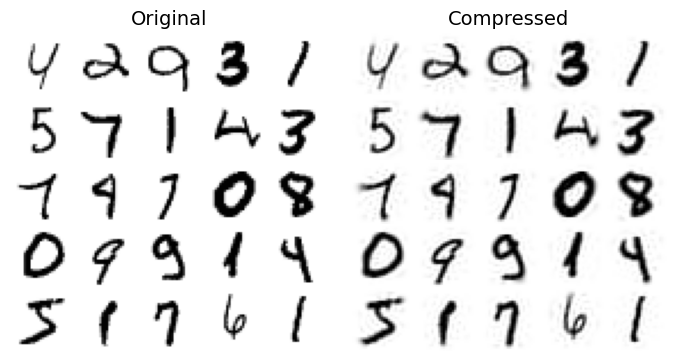

In [28]:
plt.figure(figsize=(7, 4))  # 전체 그림 크기 설정
for idx, X in enumerate((X_train[::2100], X_recovered[::2100])):  # 원본과 복원된 데이터 번갈아 처리
    plt.subplot(1, 2, idx + 1)  # 1행 2열 중 현재 subplot 설정
    plt.title(["Original", "Compressed"][idx])  # 그래프 제목 설정

    for row in range(5):  # 5행 반복
        for col in range(5):  # 5열 반복
            plt.imshow(X[row * 5 + col].reshape(28, 28), cmap="binary",  # 28x28 이미지로 변환해 흑백으로 출력
                       vmin=0, vmax=255, extent=(row, row + 1, col, col + 1))  # 픽셀값 범위와 위치 설정
            plt.axis([0, 5, 0, 5])  # 축 범위 고정
            plt.axis("off")  # 축 눈금 및 테두리 제거

save_fig("mnist_compression_plot")  # 그림 저장


화질이 약간 저하되었으나 숫자의 형태는 대부분 유지됨

[PCA 역변환(원래 차원으로 복원) 수식]

$X_{\text{recovered}} = X_{\text{d-proj}} \cdot W_d^\top$

### Randomized PCA

`svd_solver` 하이퍼파라미터를 `randomized`로 설정하면  
Scikit-Learn은 Randomized PCA라는 확률적 알고리즘을 사용해
앞의 d개 주성분을 빠르게 근사

Randomized PCA의 계산 복잡도
 - O(m × d²) + O(d³)
 - 기존 Full SVD의 O(m × n²) + O(n³)에 비해 훨씬 빠름
 - 특히 d가 n보다 훨씬 작을 때 성능 차이 큼

svd_solver의 기본값은 `auto`  
다음 조건일 때 Scikit-Learn에서 자동으로 `randomized` 사용
- m 또는 n이 500보다 크고
- d가 m 또는 n의 80% 미만일 경우
- 그 외에는 Full SVD 방식 사용

강제로 Full SVD 사용하려면 svd_solver="full"

In [30]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)  # 랜덤 기반의 확률적 PCA 실행을 위해 고정된 시드 사용
X_reduced = rnd_pca.fit_transform(X_train)  # 훈련 데이터 축소


### Incremental PCA

기존 PCA 구현 방식의 문제점은 전체 훈련 데이터를 한 번에 메모리에 적재해야 한다는 점  
→ 큰 데이터셋에서는 실행 불가능하거나 매우 비효율적

Incremental PCA (IPCA)
- 미니배치 단위로 데이터를 조금씩 받아 PCA 수행 가능
- 매우 큰 데이터셋 처리 가능
- **온라인 학습(데이터가 순차적으로 들어오는 경우)**에도 유용


1. 미니배치로 IPCA 실행





In [31]:
from sklearn.decomposition import IncrementalPCA  # 점진적 학습이 가능한 PCA 클래스 임포트

n_batches = 100  # 훈련 데이터를 100개의 미니배치로 분할
inc_pca = IncrementalPCA(n_components=154)  # 154개의 주성분을 사용해 IPCA 객체 생성
for X_batch in np.array_split(X_train, n_batches):  # 훈련 데이터를 배치 단위로 나눔
    inc_pca.partial_fit(X_batch)  # 각 배치를 사용해 부분 학습 수행

X_reduced = inc_pca.transform(X_train)  # 전체 훈련 데이터를 154차원으로 변환


2. 메모리 매핑 배열(memmap) 사용
- 메모리에 올리지 않고도 큰 배열 처리 가능
- np.memmap()은 디스크에 저장된 바이너리 파일을 배열처럼 조작 가능


In [32]:
filename = "my_mnist.mmap"  # 메모리 매핑 파일 이름 지정
X_mmap = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)  # 메모리 매핑 배열 생성
X_mmap[:] = X_train  # 전체 훈련 데이터를 메모리 매핑 배열에 복사
X_mmap.flush()  # 변경 내용을 디스크에 저장


In [33]:
X_mmap = np.memmap(filename, dtype="float32", mode="readonly").reshape(-1, 784)  # 저장된 메모리 매핑 파일을 읽고 원래 형태로 복원
batch_size = X_mmap.shape[0] // n_batches  # 전체 샘플 수를 기준으로 배치 크기 설정
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)  # 배치 크기를 지정해 IPCA 객체 생성
inc_pca.fit(X_mmap)  # 메모리 매핑된 대용량 데이터를 IPCA로 학습


IncrementalPCA(batch_size=600, n_components=154)

## Kernel PCA

**커널 트릭(kernel trick)**: 입력 데이터를 고차원 특성 공간으로 암묵적으로 매핑해 SVM으로 비선형 분류와 회귀를 가능하게 함  
→ 고차원에서의 선형 결정 경계는 원래 공간에서는 비선형 경계로 보임

이 커널 트릭을 PCA에도 적용  
→ **커널 PCA (Kernel PCA, kPCA)**  
→ 일반적인 선형 PCA보다 훨씬 복잡한 비선형 차원 축소 가능

특징
- 복잡하게 꼬인 형태(예: 스위스 롤 같은 매니폴드 구조)도 잘 펼침
- 비선형 구조를 반영한 차원 축소가 가능
- 클러스터 형태 유지에 유리


### Selecting a Kernel and Tuning Hyperparameters

## LLE

### Other Dimensionality Reduction Techniques